In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold


## Data collect

In [2]:
samples = pd.read_excel(u'20.01.23 список образцов Моча.xlsx', header=2)
samples.dropna(subset=['Gender'], inplace=True)

samples.fillna(0, inplace=True)
samples.reset_index(drop=True, inplace=True)

In [3]:
spectra1 = pd.read_csv('urine_chm001-250.csv')
spectra2 = pd.read_csv('urine_chm251-500.csv')
spectra_init = pd.concat([spectra1, spectra2],  ignore_index=True)

spectra = spectra_init.filter(regex='^Ch')

mmscaler = MinMaxScaler()
spectra = pd.DataFrame(mmscaler.fit_transform(spectra.T).T)

In [4]:
frame_lol = samples[['Dataset', 'TOTAL_a']]

spectra['Dataset'] = spectra_init['Dataset']
spectra = pd.merge(left=spectra, right=frame_lol, how='left', on='Dataset')
spectra.dropna(subset=['TOTAL_a'], inplace=True)

In [5]:
corr_df = spectra.corr(method='spearman').abs()

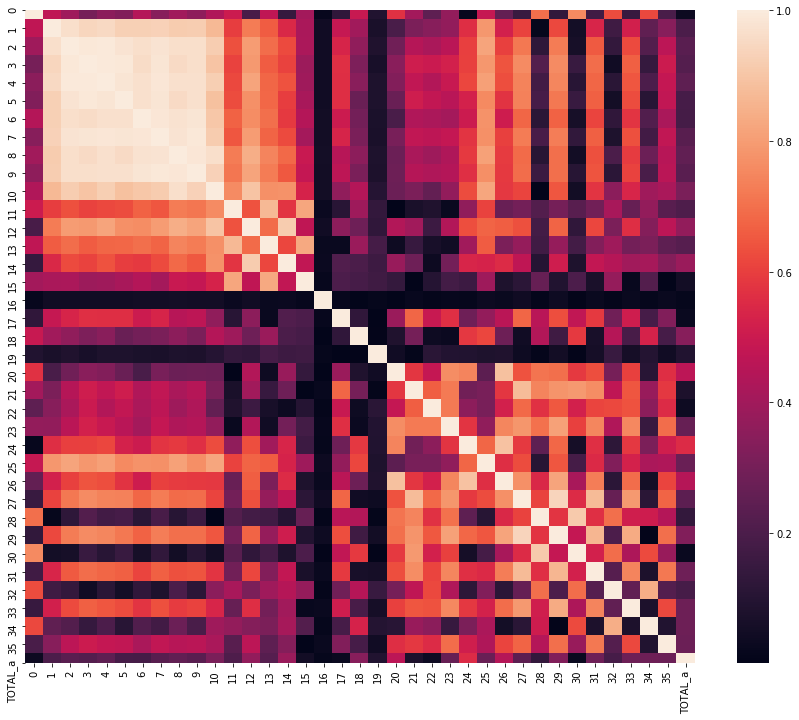

In [6]:
plt.figure(figsize=(15,12))
sns.heatmap(corr_df)

## Plotting

In [7]:
pca_model = PCA(n_components=3)
PCA_spectra = pd.DataFrame(pca_model.fit_transform(spectra.drop(['Dataset', 'TOTAL_a'], axis=1)))
PCA_spectra['target'] = spectra.TOTAL_a.values

In [32]:
PCA_spectra.to_csv('PCA_Chm_1_500.csv', index=0)

In [24]:
X = spectra.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra.TOTAL_a

In [28]:
LDA = LinearDiscriminantAnalysis(n_components=3)
LDA_spectra = pd.DataFrame(LDA.fit_transform(X,y))
LDA_spectra['target'] = y.values

In [33]:
LDA_spectra.to_csv('LDA_Chm_1_500.csv', index=0)

# Transform Data

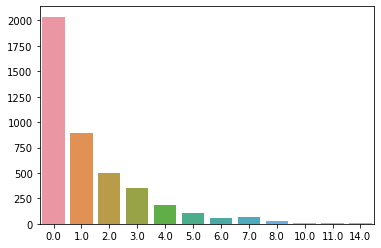

In [37]:
df = spectra['TOTAL_a'].value_counts()
sns.barplot(df.index, df.values)

In [8]:
spectra_2_groups = deepcopy(spectra)
spectra_2_groups['TOTAL_a'] = spectra_2_groups.TOTAL_a.apply(lambda x: 0 if x==0 else 1).values

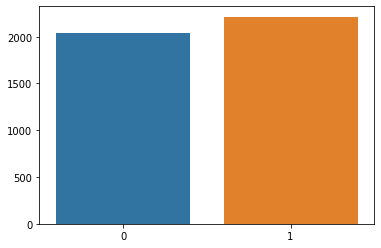

In [9]:
df = spectra_2_groups['TOTAL_a'].value_counts()
sns.barplot(df.index, df.values)

In [10]:
spectra_3_groups = deepcopy(spectra)
def mapping(x):
    if x==0: return 0
    elif 1<=x<=2: return 1
    else : return 2
    
spectra_3_groups['TOTAL_a'] = spectra_3_groups.TOTAL_a.apply(mapping).values

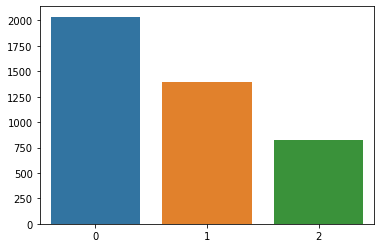

In [11]:
df = spectra_3_groups['TOTAL_a'].value_counts()
sns.barplot(df.index, df.values)

# LDA

###  2 Groups

In [12]:
X = spectra_2_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_2_groups.TOTAL_a

In [13]:
LDA = LinearDiscriminantAnalysis(n_components=1)
LDA_spectra_2groups = pd.DataFrame(LDA.fit_transform(X,y))
LDA_spectra_2groups['target'] = y.values

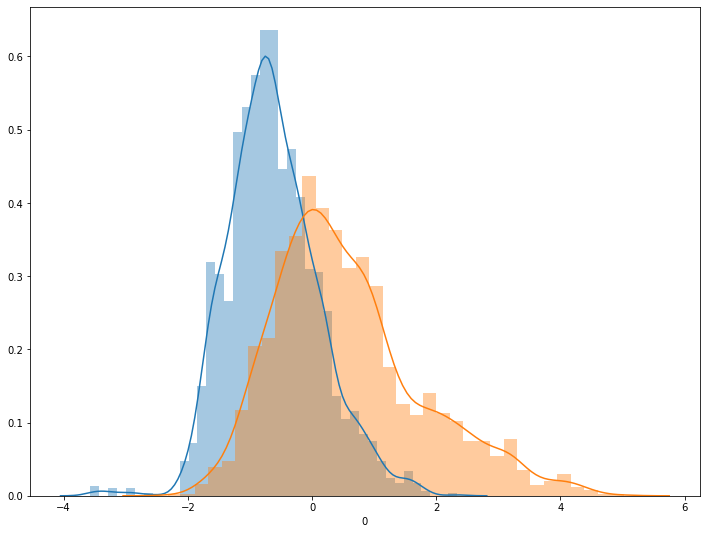

In [14]:
plt.figure(figsize=(12,9))
sns.distplot(LDA_spectra_2groups[LDA_spectra_2groups.target == 0][0])
sns.distplot(LDA_spectra_2groups[LDA_spectra_2groups.target == 1][0])

In [93]:
def metrics_ret(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return [acc, prec, rec, f1]

### CV

In [100]:
chms = spectra_2_groups.Dataset.unique()
X = spectra_2_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_2_groups.TOTAL_a

Metrics = []
for i in range(20):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=3*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=3*i)

    train_inds = list(map(lambda x: x in train_chms, spectra_2_groups.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra_2_groups.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra_2_groups.Dataset))
    
    LDA = LinearDiscriminantAnalysis(n_components=1)
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    LDA.fit(Train_X, Train_y)
    Preds = LDA.predict(Test_X)
    
    Metrics.append(metrics_ret(Test_y, Preds))
    
Metrics = pd.DataFrame(Metrics, columns=['accuracy', 'precision', 'recall', 'f-score'])

In [102]:
Metrics.describe()

,accuracy,precision,recall,f-score
count,20.000000,20.000000,20.000000,20.000000
mean,0.674674,0.709817,0.626006,0.660848
std,0.039407,0.053441,0.084137,0.050378
min,0.606596,0.622549,0.446469,0.539945
25%,0.654300,0.679060,0.558659,0.639551
50%,0.674229,0.713594,0.638214,0.664697
75%,0.700984,0.746335,0.693604,0.692951
max,0.757293,0.829352,0.772093,0.761468


###  3 Groups

In [103]:
X = spectra_3_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_3_groups.TOTAL_a

In [105]:
LDA = LinearDiscriminantAnalysis(n_components=2)
LDA_spectra_3groups = pd.DataFrame(LDA.fit_transform(X,y))
LDA_spectra_3groups['target'] = y.values

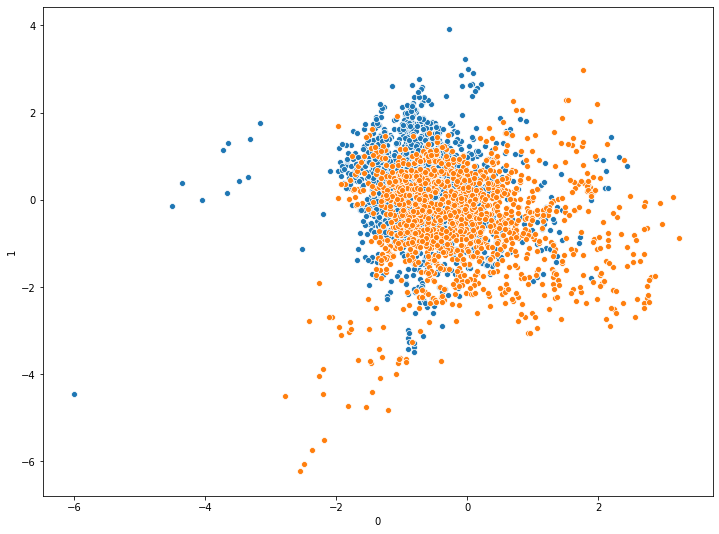

In [106]:
plt.figure(figsize=(12,9))
sns.scatterplot(LDA_spectra_3groups[LDA_spectra_3groups.target == 0][0],
                LDA_spectra_3groups[LDA_spectra_3groups.target == 0][1])
sns.scatterplot(LDA_spectra_3groups[LDA_spectra_3groups.target == 1][0],
                LDA_spectra_3groups[LDA_spectra_3groups.target == 1][1])

In [167]:
def metrics_ret_macro(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return [acc, prec, rec, f1]

### CV

In [141]:
chms = spectra_3_groups.Dataset.unique()
X = spectra_3_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_3_groups.TOTAL_a

Metrics = []
for i in range(20):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=2*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=2*i)

    train_inds = list(map(lambda x: x in train_chms, spectra_3_groups.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra_3_groups.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra_3_groups.Dataset))
    
    LDA = LinearDiscriminantAnalysis(n_components=2)
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    LDA.fit(Train_X, Train_y)
    Preds = LDA.predict(Test_X)
    
    Metrics.append(classification_report(Test_y, Preds))

In [121]:
print(Metrics[-1])

              precision    recall  f1-score   support

           0       0.65      0.80      0.71       442
           1       0.39      0.33      0.35       251
           2       0.87      0.54      0.67       164

    accuracy                           0.61       857
   macro avg       0.64      0.56      0.58       857
weighted avg       0.61      0.61      0.60       857



# QDA

In [145]:
chms = spectra_2_groups.Dataset.unique()
X = spectra_2_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_2_groups.TOTAL_a

Metrics = []
for i in range(30):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=2*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=2*i)

    train_inds = list(map(lambda x: x in train_chms, spectra_2_groups.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra_2_groups.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra_2_groups.Dataset))
    
    QDA = QuadraticDiscriminantAnalysis(priors=[0.3, 0.7])
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    QDA.fit(Train_X, Train_y)
    Preds = QDA.predict(Test_X)
    
    Metrics.append(metrics_ret(Test_y, Preds))
    
Metrics = pd.DataFrame(Metrics, columns=['accuracy', 'precision', 'recall', 'f-score'])

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWa

In [146]:
Metrics.describe()

,accuracy,precision,recall,f-score
count,30.000000,30.000000,30.000000,30.000000
mean,0.659541,0.762027,0.519182,0.607462
std,0.043090,0.069814,0.103932,0.075094
min,0.553444,0.597674,0.229508,0.373333
25%,0.636095,0.727282,0.462231,0.574392
50%,0.658038,0.761987,0.532169,0.616007
75%,0.684059,0.800229,0.567862,0.645693
max,0.760000,1.000000,0.749398,0.741359


In [148]:
chms = spectra_3_groups.Dataset.unique()
X = spectra_3_groups.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra_3_groups.TOTAL_a

Metrics = []
for i in range(30):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=2*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=2*i)

    train_inds = list(map(lambda x: x in train_chms, spectra_3_groups.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra_3_groups.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra_3_groups.Dataset))
    
    QDA = QuadraticDiscriminantAnalysis(priors=[0.2, 0.3, 0.5])
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    QDA.fit(Train_X, Train_y)
    Preds = QDA.predict(Test_X)
    
    Metrics.append(metrics_ret_micro(Test_y, Preds))
    
Metrics = pd.DataFrame(Metrics, columns=['accuracy', 'precision', 'recall', 'f-score'])

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWa

In [149]:
Metrics.describe()

,accuracy,precision,recall,f-score
count,30.000000,30.000000,30.000000,30.000000
mean,0.505806,0.488297,0.479713,0.455268
std,0.094169,0.075553,0.071388,0.101025
min,0.190813,0.262468,0.249319,0.147746
25%,0.497084,0.460955,0.446211,0.446283
50%,0.522334,0.500472,0.487260,0.481228
75%,0.564915,0.533076,0.516099,0.516251
max,0.642353,0.589268,0.637480,0.595527


In [169]:
chms = spectra.Dataset.unique()
X = spectra.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra.TOTAL_a

Metrics = []
for i in range(20):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=3*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=3*i)

    train_inds = list(map(lambda x: x in train_chms, spectra.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra.Dataset))
    
    LDA = LinearDiscriminantAnalysis(n_components=5)
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    LDA.fit(Train_X, Train_y)
    Preds = LDA.predict(Test_X)
    
    Metrics.append(metrics_ret_macro(Test_y, Preds))
    
Metrics = pd.DataFrame(Metrics, columns=['accuracy', 'precision', 'recall', 'f-score'])

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/minicond

/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

In [170]:
Metrics.describe()

,accuracy,precision,recall,f-score
count,20.000000,20.000000,20.000000,20.000000
mean,0.449807,0.145872,0.135130,0.127744
std,0.060180,0.042083,0.026935,0.028050
min,0.224178,0.085992,0.091833,0.085955
25%,0.436299,0.115678,0.119215,0.107119
50%,0.465021,0.139292,0.129373,0.123489
75%,0.477100,0.170125,0.152746,0.146228
max,0.521790,0.247934,0.190115,0.194974


#  PLS

In [172]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [171]:
X = spectra.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra.TOTAL_a

In [173]:
def metrics_reg(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return [r2, rmse, mae]

In [174]:
PLS = PLSRegression(n_components=3)
Metrics = []
for i in range(30):
    tr_val_chms, test_chms, _, _, = train_test_split(chms, chms, test_size=0.2, random_state=2*i)
    train_chms, val_chms, _, _, = train_test_split(tr_val_chms, tr_val_chms, test_size=0.2, random_state=2*i)

    train_inds = list(map(lambda x: x in train_chms, spectra_3_groups.Dataset))
    val_inds = list(map(lambda x: x in val_chms, spectra_3_groups.Dataset))
    test_inds = list(map(lambda x: x in test_chms, spectra_3_groups.Dataset))
    
    PLS = PLSRegression(n_components=3)
    Train_X, Test_X = X[train_inds], X[test_inds]
    Train_y, Test_y = y[train_inds], y[test_inds]
    PLS.fit(Train_X, Train_y)
    Preds = PLS.predict(Test_X)
    
    Metrics.append(metrics_reg(Test_y, Preds))
    
Metrics = pd.DataFrame(Metrics, columns=['R2 Score', 'RMSE', 'MAE'])

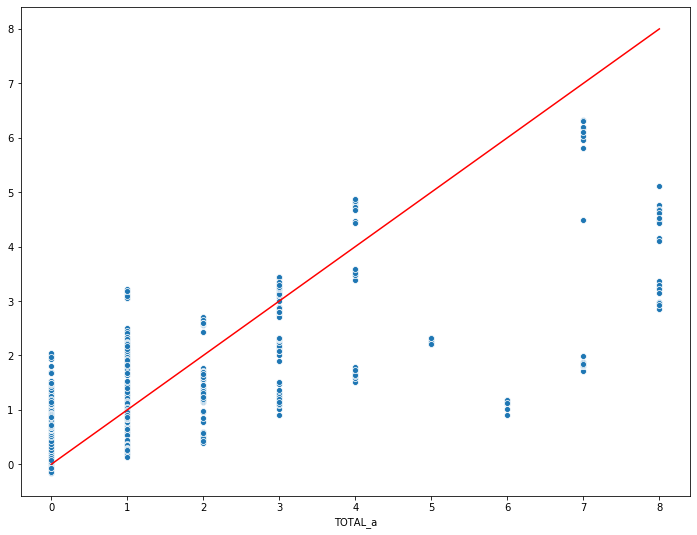

In [183]:
plt.figure(figsize=(12,9))
sns.scatterplot(Test_y, Preds.reshape(-1))
plt.plot(Test_y, Test_y, c='r')

In [176]:
Metrics.describe()

,R2 Score,RMSE,MAE
count,30.000000,30.000000,30.000000
mean,0.333090,1.550701,1.054542
std,0.301146,0.328360,0.113725
min,-1.153191,1.155636,0.807296
25%,0.336637,1.414248,0.984439
50%,0.409596,1.502360,1.059014
75%,0.451189,1.596391,1.104794
max,0.554378,3.095271,1.391573
